In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os 
from zipfile import ZipFile, ZIP_DEFLATED
from scipy.special import voigt_profile
import math

Choose the peak density

In [44]:
peak_densities_all = ['small', 'medium', 'large', 'very_large']
peak_density = peak_densities_all[3]

np.random.seed(42) # for reproducibility
num_repetitions = 1500
num_xs = 11837
x = np.linspace(0, 10, num_xs)

signals_voigt = np.zeros((num_repetitions, len(x)))
signals_lor = np.zeros((num_repetitions, len(x)))
signals_gauss = np.zeros((num_repetitions, len(x)))
signals_asg = np.zeros((num_repetitions, len(x)))

func_params = []
all_peaks = []
binary_peaks_voigt = np.zeros((num_repetitions, num_xs))
binary_peaks_lor = np.zeros((num_repetitions, num_xs))
binary_peaks_gauss = np.zeros((num_repetitions, num_xs))
binary_peaks_asg = np.zeros((num_repetitions, num_xs))

Choose the number of peaks

In [45]:
for i in range(num_repetitions):
    if peak_density == 'small':
        n_func = np.random.randint(5, 20)
    elif peak_density == 'medium':
        n_func = np.random.randint(20,50)
    elif peak_density == 'large':
        n_func = np.random.randint(50, 100)
    else: n_func = np.random.randint(100, 200)


Choose other parameters, same for all three types of peak shapes

In [46]:
for i in range(num_repetitions):  
    used_means = []
    b_lst = []
    stddev_lst = []
    mix_param_lst = []
    amp_lst = []

    # Generate all parameters for all peak types
    for _ in range(n_func):
        attempts = 0

        while True:
            b = np.random.uniform(0.001,0.05) # half width half max (HWHM) for L
            stddev = b / np.sqrt(2 * np.log(2)) # convert b to std dev
            mix_param = np.random.uniform(0.2,0.8) # used for voigt
            amp = np.random.uniform(0.01, 1.00)
            fwhm = 2 * np.sqrt(2 * np.log(2)) * stddev

            min_d = fwhm * 2
            center = np.random.uniform(0,10)
            if all(abs(center - m) >= min_d for m in used_means):
                used_means.append(center)
                b_lst.append(b)
                stddev_lst.append(stddev)
                mix_param_lst.append(mix_param)
                amp_lst.append(amp)

                break
            attempts += 1
            if attempts > 500: # avoid inf loop
                break
            
    signal_v = np.zeros(num_xs, )
    signal_l = np.zeros(num_xs, )
    signal_g = np.zeros(num_xs, )
    signal_asg = np.zeros(num_xs, )

    peaks = []
    
    # pseudo-Voigt
    for func in range(n_func):
        lor = b / ((x - used_means[func])**2 + b**2)
        lor /= np.max(lor)
        gau = np.exp(-((x - used_means[func])**2) / (2 * stddev_lst[func]**2))
        pseudo_V = (mix_param_lst[func] * lor + (1 - mix_param_lst[func]) * gau)
        pseudo_V *= amp_lst[func]
        signal_v += pseudo_V

        peak_index = np.argmax(pseudo_V)
        peaks.append(peak_index)
        trim_min, trim_max = (used_means[func] - (b_lst[func]) / 2, used_means[func] + (b_lst[func]) / 2)

        # Create a boolean mask where x_values are between trim_min and trim_max
        trim_mask = (x >= trim_min) & (x <= trim_max)

        add_ones = np.where(trim_mask == True)[0]
        binary_peaks_voigt[i][add_ones] = 1
    
    signals_voigt[i] = signal_v
    
     # Lorentzian
    for func in range(n_func):
        lor = (1 / math.pi) * (b_lst[func] / ((x - used_means[func])**2 + b_lst[func]**2))
        lor /= np.max(lor)
        lor *= amp_lst[func]
        signal_l += lor

        peak_index = np.argmax(lor)
        peaks.append(peak_index)
        trim_min, trim_max = (used_means[func] - (b_lst[func]) / 2, used_means[func] + (b_lst[func]) / 2)

        # Create a boolean mask where x_values are between trim_min and trim_max
        trim_mask = (x >= trim_min) & (x <= trim_max)
        add_ones = np.where(trim_mask == True)[0]
        binary_peaks_lor[i][add_ones] = 1
    
    signals_lor[i] = signal_l

    # Gaussian
    for func in range(n_func): 
        gau = np.exp(-((x - used_means[func])**2) / (2 * stddev_lst[func]**2))
        gau *= amp_lst[func]
        signal_g += gau

        peak_index = np.argmax(gau)
        peaks.append(peak_index)
        trim_min, trim_max = (used_means[func] - (b_lst[func]) / 2, used_means[func] + (b_lst[func]) / 2)
        
        # Create a boolean mask where x_values are between trim_min and trim_max
        trim_mask = (x >= trim_min) & (x <= trim_max)
        add_ones = np.where(trim_mask == True)[0]
        binary_peaks_gauss[i][add_ones] = 1

    signals_gauss[i] = signal_g

    # asymmetric split Gaussian
    for func in range(n_func):
        stddev_choices = [b * 0.8, b* 0.9, b * 1.0, b * 1.1, b * 1.2] # 10 % or 20 % asymmetry and peaks cannot be symmetric at all
        stddev_l, stddev_r = np.random.choice(stddev_choices, size=2, replace=False)
        fwhm_l = 2 * np.sqrt(2 * np.log(2)) * stddev_l
        fwhm_r = 2 * np.sqrt(2 * np.log(2)) * stddev_r

        left_mask = x <= used_means[func]
        right_mask = x > used_means[func]

        signal_asg[left_mask] += amp_lst[func] * np.exp(-0.5 * ((x[left_mask] - used_means[func]) / stddev_l)**2)
        signal_asg[right_mask] += amp_lst[func] * np.exp(-0.5 * ((x[right_mask] - used_means[func]) / stddev_r)**2)

        peak_index = np.argmax(signal_asg)
        peaks.append(peak_index)
        
        trim_min, trim_max = (used_means[func] - max(fwhm_l, fwhm_r) / 4, used_means[func] + max(fwhm_l, fwhm_r) / 4)

        # Create a boolean mask where x_values are between trim_min and trim_max
        trim_mask = (x >= trim_min) & (x <= trim_max)

        add_ones = np.where(trim_mask == True)[0]
        binary_peaks_asg[i][add_ones] = 1

    signals_asg[i] = signal_asg

   

In [47]:
%matplotlib widget

can scale by total intensity (a thing to check) (normalize by the np.sum(signals[i]) before adding noise)
will make all the intensities really low but hte sum is 1
do this for all three

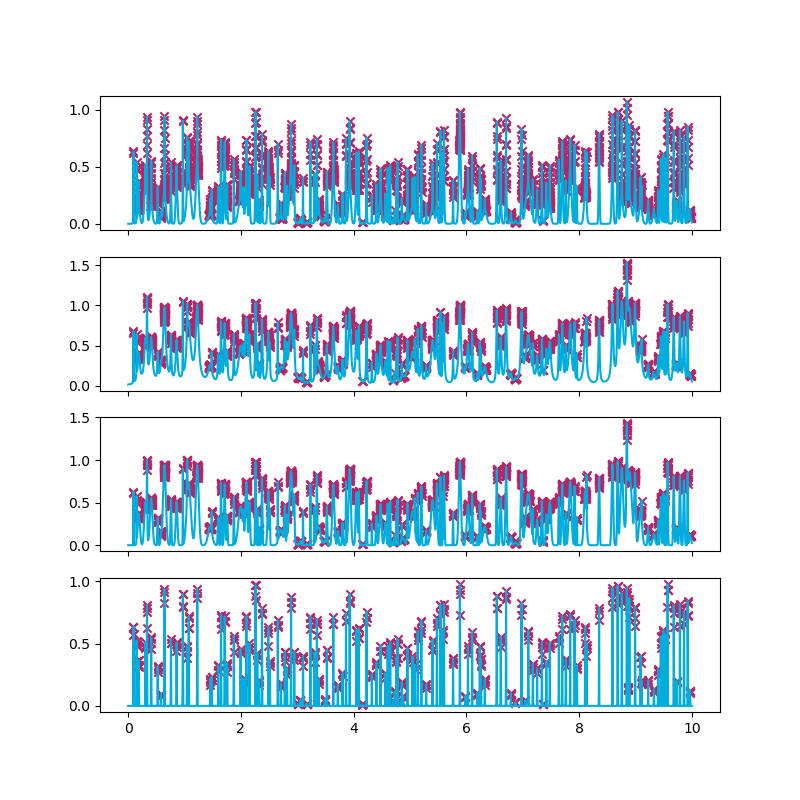

In [48]:
i=3

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(8,8))

all_ones_voigt = np.where(binary_peaks_voigt[i] > 0)[0]
all_ones_lor = np.where(binary_peaks_lor[i] > 0)[0]
all_ones_gauss = np.where(binary_peaks_gauss[i] > 0)[0]
all_ones_asg = np.where(binary_peaks_asg[i] > 0)[0]

axs[0].plot(x, signals_voigt[i], color='#00ADDC')
axs[0].scatter(x[all_ones_voigt], signals_voigt[i][all_ones_voigt], marker='x', color='#B72467')

axs[1].plot(x, signals_lor[i], color='#00ADDC')
axs[1].scatter(x[all_ones_lor], signals_lor[i][all_ones_lor], marker='x', color='#B72467')

axs[2].plot(x, signals_gauss[i], color='#00ADDC')
axs[2].scatter(x[all_ones_gauss], signals_gauss[i][all_ones_gauss], marker='x', color='#B72467')

axs[3].plot(x, signals_asg[i], color='#00ADDC')
axs[3].scatter(x[all_ones_asg], signals_asg[i][all_ones_asg], marker='x', color='#B72467')

plt.show()




In [49]:
np.where(signals_lor[i] > 9)

(array([], dtype=int64),)

In [50]:
print(signals_voigt[i][11311:11324])

print(signals_lor[i][11311:11324])

print(signals_gauss[i][11311:11324])

[0.09701963 0.12360797 0.15565435 0.19348225 0.23719731 0.28663587
 0.3413335  0.40052713 0.46320779 0.52824624 0.59462306 0.66180353
 0.73026002]
[0.28338817 0.30683777 0.33364151 0.36428518 0.39929576 0.43921586
 0.48455383 0.53569625 0.5927666  0.65541519 0.72253794 0.79195584
 0.86015064]
[0.11402478 0.1479931  0.18886709 0.23699745 0.29241769 0.35476126
 0.42319575 0.49638539 0.57249179 0.64922032 0.72391492 0.79369843
 0.85564988]


In [51]:
def add_noise_by_percentage(signal, noise_percentage):
        """
        Add random noise to a NumPy array based on a percentage of the maximum signal value.

        Parameters:
            signal (numpy.ndarray): The original signal array.
            noise_percentage (float): Percentage of the maximum signal value to use as noise.

        Returns:
            noisy_signal (numpy.ndarray): The signal array with added noise.
        """
        # Find the maximum value in the signal
        max_value = np.max(np.abs(signal))

        # Calculate the noise standard deviation as a percentage of the max signal value
        noise_std = (noise_percentage / 100) * max_value

        # Generate random Gaussian noise with zero mean and calculated standard deviation
        noise = np.random.normal(0.005, noise_std, signal.shape)

        # Add the noise to the original signal
        noisy_signal = signal + noise

        return noisy_signal
noise_level = 0.05
noisy_signals_voigt = add_noise_by_percentage(signals_voigt, noise_level)
noisy_signals_lor = add_noise_by_percentage(signals_lor, noise_level)
noisy_signals_gauss = add_noise_by_percentage(signals_gauss, noise_level)
noisy_signals_asg = add_noise_by_percentage(signals_asg, noise_level)

In [52]:
ds_voigt = xr.Dataset(
    {
        "Intensities": (["pattern", "x"], noisy_signals_voigt),
        "BinaryArr": (["pattern", "x"], binary_peaks_voigt)
    },
    coords = {
        "pattern": np.arange(num_repetitions),
        "x": np.linspace(1, 10, x.shape[0])
    },
    attrs={
        "description": "Simulated p-voigt signals with labeled peaks, padded with 1s along mean +- b/2",
        "min_d_rule": "Minimum distance is fwhm*2",
        "fwhm_definition": "FWHM = 2 * HWHM (b); used in min_d calculation",
        "note": f"Each pattern contains a {peak_density} number of peaks. Used_means enforces peak spacing.",
        "params": "a=np.random.uniform(0,10),  b = np.random.uniform(0.001,0.05), mix_param = np.random.uniform(0.2,0.8), amp = np.random.uniform(0.01, 1.00) with seed=42",
        "noise": f"True, {noise_level}%",
        "number": f"{num_repetitions} patterns",
        "additional_notes": "same params and means as L and G for training set comparison purposes"
    }
)

In [53]:
ds_lor = xr.Dataset(
    {
        "Intensities": (["pattern", "x"], noisy_signals_lor),
        "BinaryArr": (["pattern", "x"], binary_peaks_lor)
    },
    coords = {
        "pattern": np.arange(num_repetitions),
        "x": np.linspace(1, 10, x.shape[0])
    },
    attrs={
        "description": "Simulated lor signals with labeled peaks, padded with 1s along mean +- b/2",
        "min_d_rule": "Minimum distance is fwhm*2",
        "fwhm_definition": "FWHM = 2 * HWHM (b); used in min_d calculation",
        "note": f"Each pattern contains a {peak_density} number of peaks. Used_means enforces peak spacing.",
        "params": "a=np.random.uniform(0,10),  b = np.random.uniform(0.001,0.05), amp = np.random.uniform(0.01, 1.00) with seed=42",
        "noise": f"True, {noise_level}%",
        "number": f"{num_repetitions} patterns",
        "additional_notes": "same params and means as p-V and G for training set comparison purposes"
    }
)

In [54]:
ds_gau = xr.Dataset(
    {
        "Intensities": (["pattern", "x"], noisy_signals_gauss),
        "BinaryArr": (["pattern", "x"], binary_peaks_gauss)
    },
    coords = {
        "pattern": np.arange(num_repetitions),
        "x": np.linspace(1, 10, x.shape[0])
    },
    attrs={
        "description": "Simulated gauss signals with labeled peaks, padded with 1s along mean +- b/2",
        "min_d_rule": "Minimum distance is fwhm*2",
        "fwhm_definition": "FWHM = 2 * HWHM (b); used in min_d calculation",
        "note": f"Each pattern contains a {peak_density} number of peaks. Used_means enforces peak spacing.",
        "params": "a=np.random.uniform(0,10),  b = np.random.uniform(0.001,0.05), amp = np.random.uniform(0.01, 1.00) with seed=42",
        "noise": f"True, {noise_level}%",
        "number": f"{num_repetitions} patterns",
        "additional_notes": "same params and means as G and L for training set comparison purposes"
    }
)

In [55]:
ds_asg = xr.Dataset(
    {
        "Intensities": (["pattern", "x"], noisy_signals_asg),
        "BinaryArr": (["pattern", "x"], binary_peaks_asg)
    },
    coords = {
        "pattern": np.arange(num_repetitions),
        "x": np.linspace(1, 10, x.shape[0])
    },
    attrs={
        "description": "Simulated asymmetric gaussian signals with labeled peaks, padded with 1s along mean +- b/2",
        "min_d_rule": "Minimum distance is fwhm*2",
        "fwhm_definition": "FWHM = 2 * HWHM (b); used in min_d calculation",
        "note": f"Each pattern contains a {peak_density} number of peaks. Used_means enforces peak spacing.",
        "params": "a=np.random.uniform(0,10),  b = np.random.uniform(0.001,0.05), stddev is [0.8*stddev, 1.0*stddev, 1.2*stddev] with no symmetry allowed, amp = np.random.uniform(0.01, 1.00) with seed=42",
        "noise": f"True, {noise_level}%",
        "number": f"{num_repetitions} patterns",
        "additional_notes": "same params and means as G,L,p-V for training set comparison purposes"
    }
)

In [56]:
# Save pseudo voigts
path = '../saved_data/'
file_pv = f'compare_pv_{peak_density}_{num_repetitions}.nc'

ds_voigt.to_netcdf(os.path.join(path, file_pv))
with ZipFile(os.path.join(path,file_pv.replace('.nc','.zip')), 'w', ZIP_DEFLATED) as zObject:
    zObject.write(os.path.join(path,file_pv), arcname=file_pv)

# Save Lorentzians
path = '../saved_data/'
file_L = f'compare_L_{peak_density}_{num_repetitions}.nc'

ds_lor.to_netcdf(os.path.join(path, file_L))
with ZipFile(os.path.join(path,file_L.replace('.nc','.zip')), 'w', ZIP_DEFLATED) as zObject:
    zObject.write(os.path.join(path,file_L), arcname=file_L)

# Save Gaussians
path = '../saved_data/'
file_G = f'compare_G_{peak_density}_{num_repetitions}.nc'

ds_gau.to_netcdf(os.path.join(path, file_G))
with ZipFile(os.path.join(path,file_G.replace('.nc','.zip')), 'w', ZIP_DEFLATED) as zObject:
    zObject.write(os.path.join(path,file_G), arcname=file_G)


In [57]:
# Save asymmetric split Gaussians
path = '../saved_data/'
file_ASG = f'compare_ASG_{peak_density}_{num_repetitions}.nc'

ds_asg.to_netcdf(os.path.join(path, file_ASG))
with ZipFile(os.path.join(path,file_ASG.replace('.nc','.zip')), 'w', ZIP_DEFLATED) as zObject:
    zObject.write(os.path.join(path,file_ASG), arcname=file_ASG)